# 基于深度学习的 MZM 导频法闭环控制（数据集生成 / 训练 / 推理）

本 Notebook 的目标：
- 只使用 PD 输出的导频 1f/2f **功率(dBm)**（不使用 DC 光功率/不依赖高速 RF 可观测）。
- 目标角度范围：**0–180°**（对应单个周期半波）。
- 将 **数据集生成 → 训练 → 推理/回放** 拆开，便于复用先前产物。

In [23]:
from __future__ import annotations

import importlib
import numpy as np

# Reusable pipeline module (reload to pick up edits)
import mzm.dither_controller as dc
dc = importlib.reload(dc)


## 数据集生成

数据集会保存到 `artifacts/`，下次可直接加载复用。

In [24]:
# Use Path objects to avoid string/path mistakes
DATASET_PATH = 'artifacts/dither_dataset_dbm_hist.npz'

device_params = dc.DeviceParams()
dither_params = dc.DitherParams()

# Generate (or overwrite) dataset artifact
ds0 = dc.generate_dataset_dbm_hist(
    device_params=device_params,
    dither_params=dither_params,
    n_samples=8000,
    seed=0,
    teacher_gain=0.5,
    max_step_V=0.2,
 )
dc.save_dataset(ds0, DATASET_PATH)
print('saved dataset:', DATASET_PATH)

ds = dc.load_dataset(DATASET_PATH)
print('Xn:', ds['Xn'].shape, 'y:', ds['y'].shape)
print('mu:', ds['mu'].shape, 'sigma:', ds['sigma'].shape)
print('device_params:', ds['device_params'])
print('dither_params:', ds['dither_params'])


saved dataset: artifacts/dither_dataset_dbm_hist.npz
Xn: (8000, 7) y: (8000, 1)
mu: (7,) sigma: (7,)
device_params: DeviceParams(Vpi_DC=5.0, ER_dB=30.0, IL_dB=6.0, Pin_dBm=10.0, Responsivity=0.786, R_load=50.0)
dither_params: DitherParams(V_dither_amp=0.05, f_dither=10000.0, Fs=2000000.0, n_periods=120)


## 训练

训练输出保存到 `artifacts/dither_policy_dbm_hist.pt`，可重复加载复用。

In [25]:
MODEL_PATH = 'artifacts/dither_policy_dbm_hist.pt'

# 如果你想跳过训练，直接用已有模型：
# - 确保 MODEL_PATH 存在，然后跳过本单元

model = dc.train_policy(
    Xn=ds['Xn'],
    y=ds['y'],
    epochs=2000,
    batch=256,
    lr=1e-3,
    hidden=64,
    depth=3,
    seed=0,
 )

dc.save_model(
    model=model,
    mu=ds['mu'],
    sigma=ds['sigma'],
    device_params=ds['device_params'],
    dither_params=ds['dither_params'],
    path=MODEL_PATH,
 )
print('saved model:', MODEL_PATH)

epoch     1 | train_mse=2.2211e-02
epoch   200 | train_mse=2.1252e-04
epoch   400 | train_mse=1.2315e-04
epoch   600 | train_mse=7.4352e-05
epoch   800 | train_mse=5.3100e-05
epoch  1000 | train_mse=1.8189e-05
epoch  1200 | train_mse=1.0821e-04
epoch  1400 | train_mse=1.1464e-05
epoch  1600 | train_mse=6.0361e-06
epoch  1800 | train_mse=6.9519e-06
epoch  2000 | train_mse=2.6209e-06
saved model: artifacts/dither_policy_dbm_hist.pt


## 推理/回放（单目标角度 + 逐轮过程 + 前后光谱对比）

- 选择一个 `target_deg` 作为锁定目标；
- 展示每一轮迭代的观测与动作（`p1/p2`、差分、`ΔV`、`V`、`θ`、误差）；
- 在初始偏置与终止偏置分别绘制一次**光谱/电谱**用于前后对比。

target_deg     : 0.0
init V (V)     : 1.9060413427103073
init theta (deg): 68.61748833757107

[pre] spectra at V_init


d:\code\python-mzm\mzm\dither_controller.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(Path(path), map_location="cpu")


pre  P_pd_avg_dBm: 2.0667613829923264

[rollout] final V: 0.0
[rollout] final wrapped err (deg): +0.00

Per-iteration trace:
 iter |    V(V) |  theta(deg) |  err(deg) |   dV(V) |  p1(dBm) |  p2(dBm) | dp1(dB) | dp2(dB)
    1 |  1.7070 |     61.453 |  -61.453 | -0.1990 |   -47.36 |   -97.60 |    0.00 |    0.00
    2 |  1.5078 |     54.279 |  -54.279 | -0.1993 |   -47.87 |   -95.25 |   -0.51 |    2.35
    3 |  1.3084 |     47.104 |  -47.104 | -0.1993 |   -48.55 |   -93.51 |   -0.68 |    1.74
    4 |  1.1091 |     39.929 |  -39.929 | -0.1993 |   -49.44 |   -92.18 |   -0.89 |    1.33
    5 |  0.9100 |     32.759 |  -32.759 | -0.1992 |   -50.59 |   -91.14 |   -1.15 |    1.04
    6 |  0.7107 |     25.587 |  -25.587 | -0.1992 |   -52.07 |   -90.34 |   -1.48 |    0.80
    7 |  0.5114 |     18.411 |  -18.411 | -0.1993 |   -54.03 |   -89.73 |   -1.96 |    0.61
    8 |  0.3126 |     11.252 |  -11.252 | -0.1989 |   -56.75 |   -89.29 |   -2.72 |    0.44
    9 |  0.1635 |      5.885 |   -5.885 | -0.

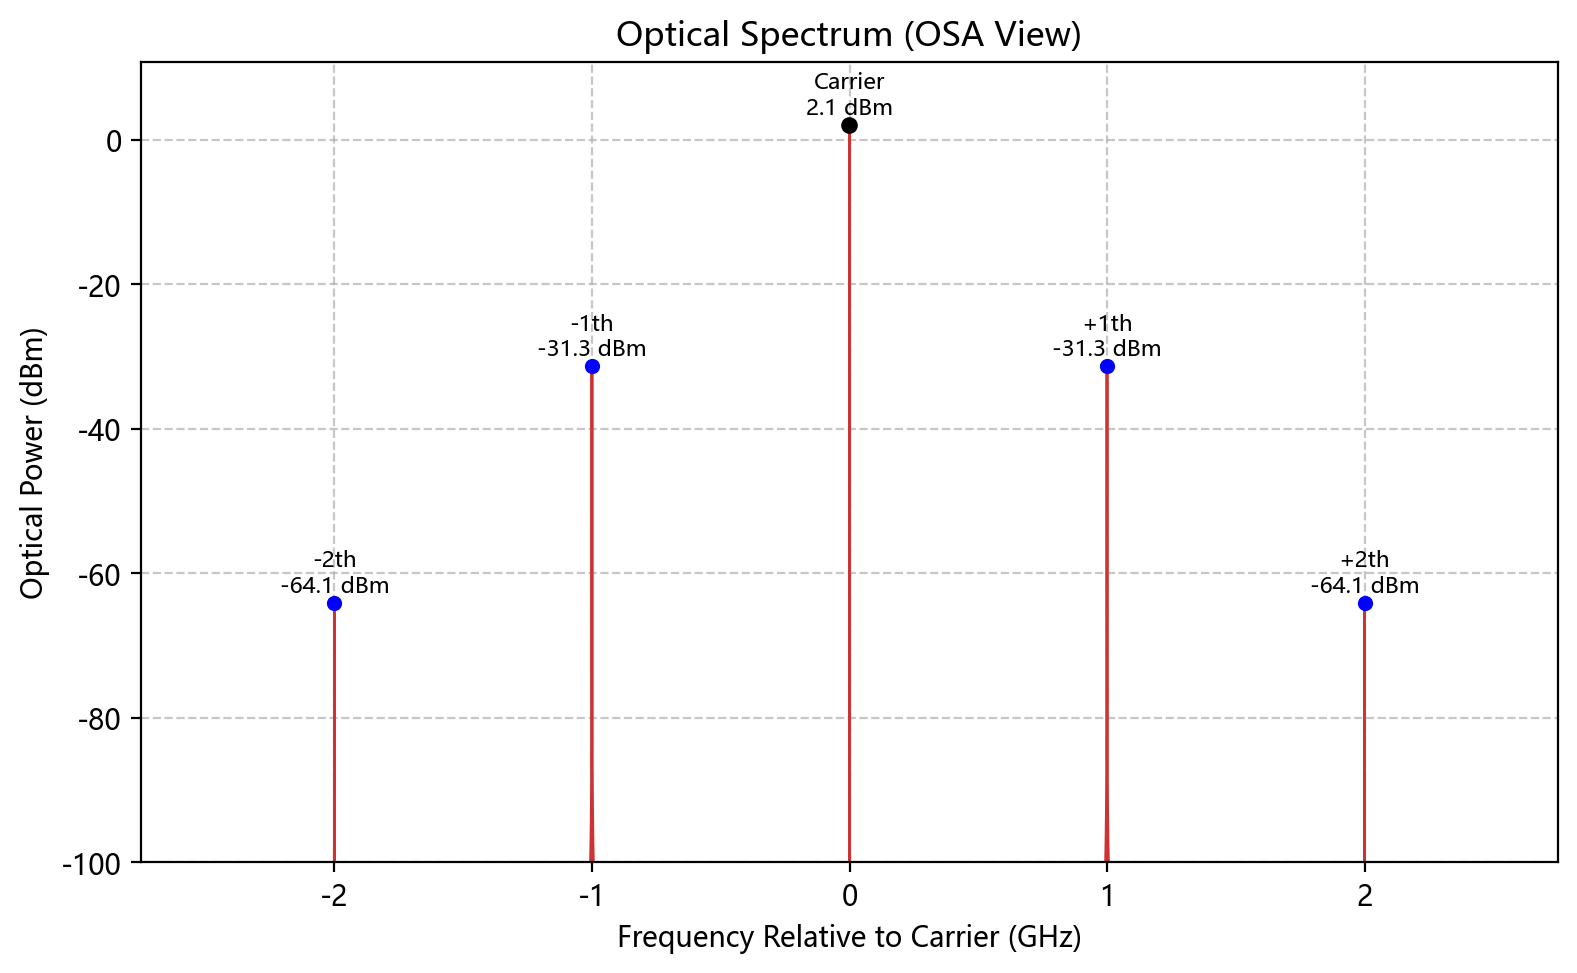

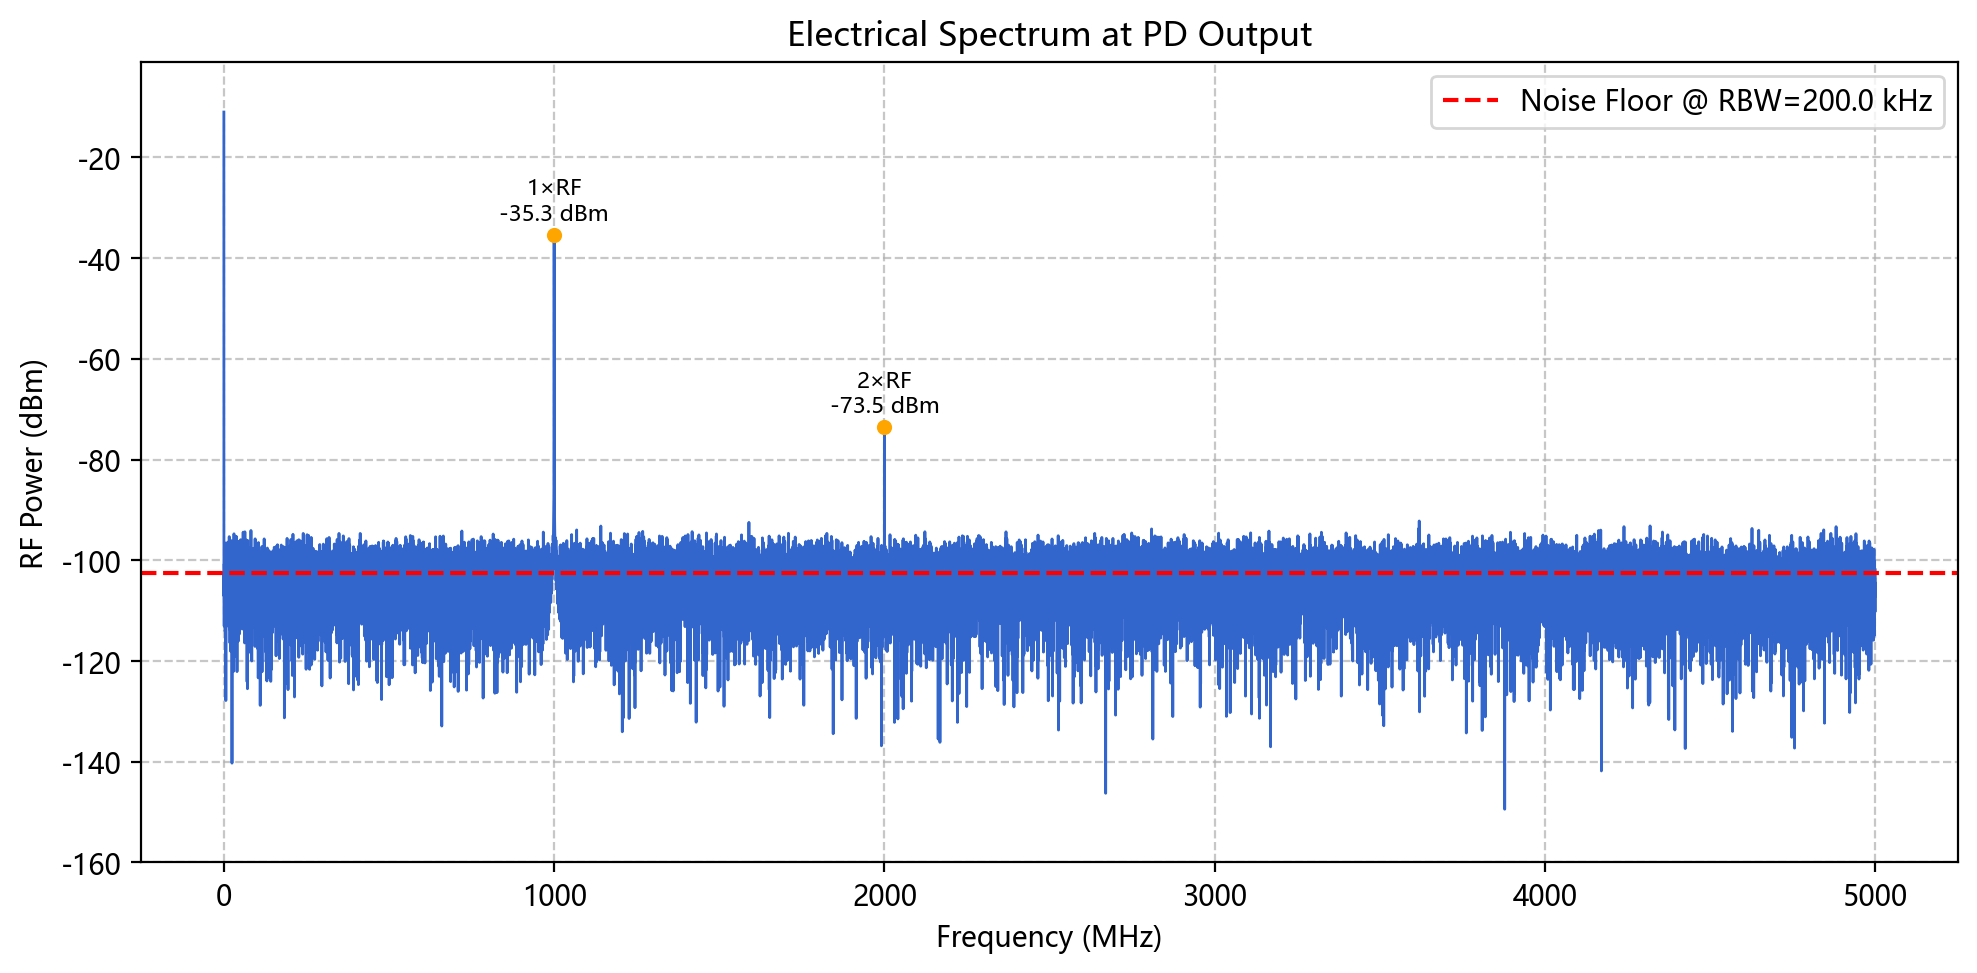

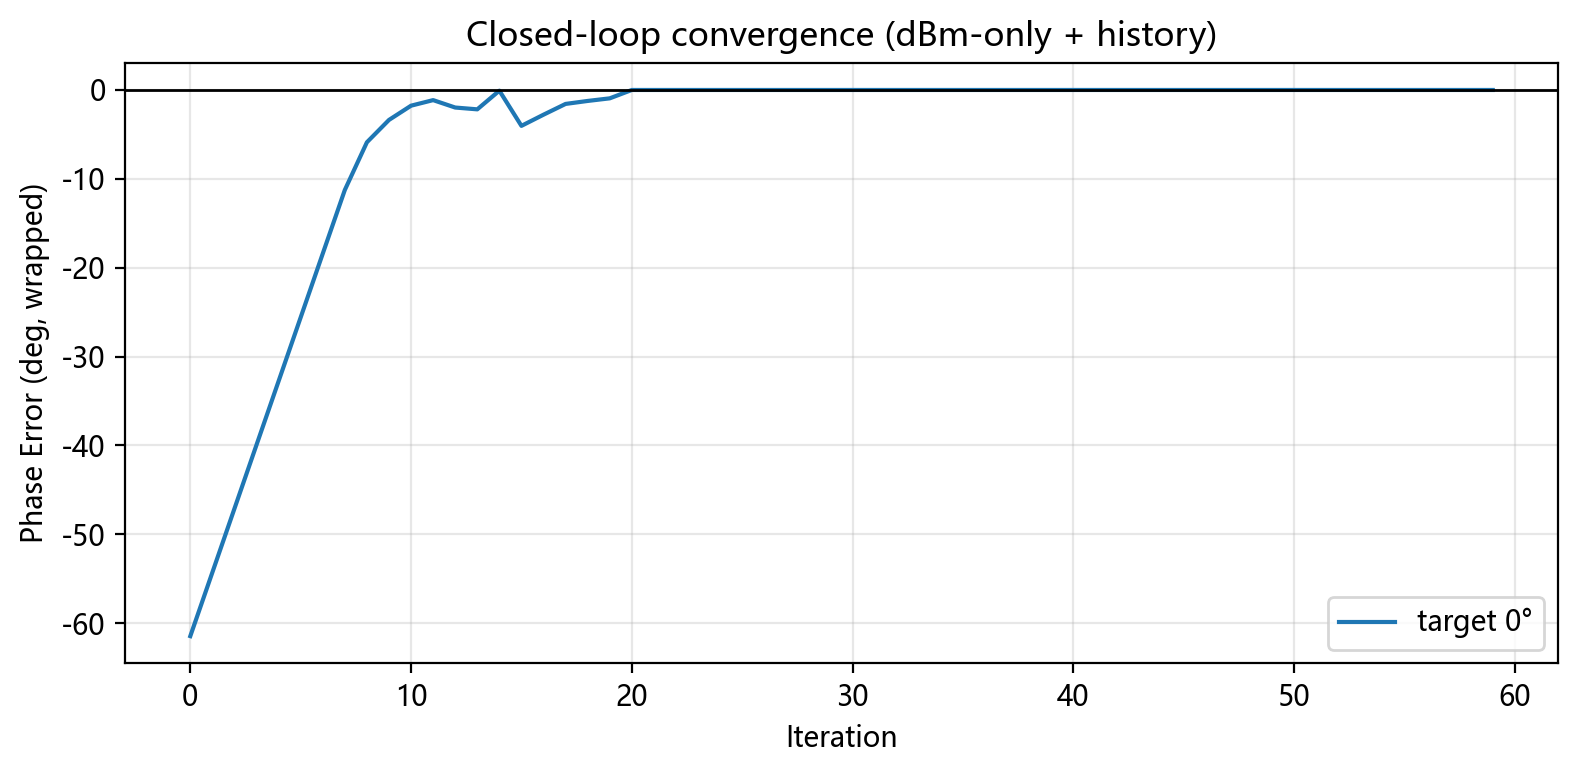


[post] spectra at V_final
post P_pd_avg_dBm: 3.7210175284673124


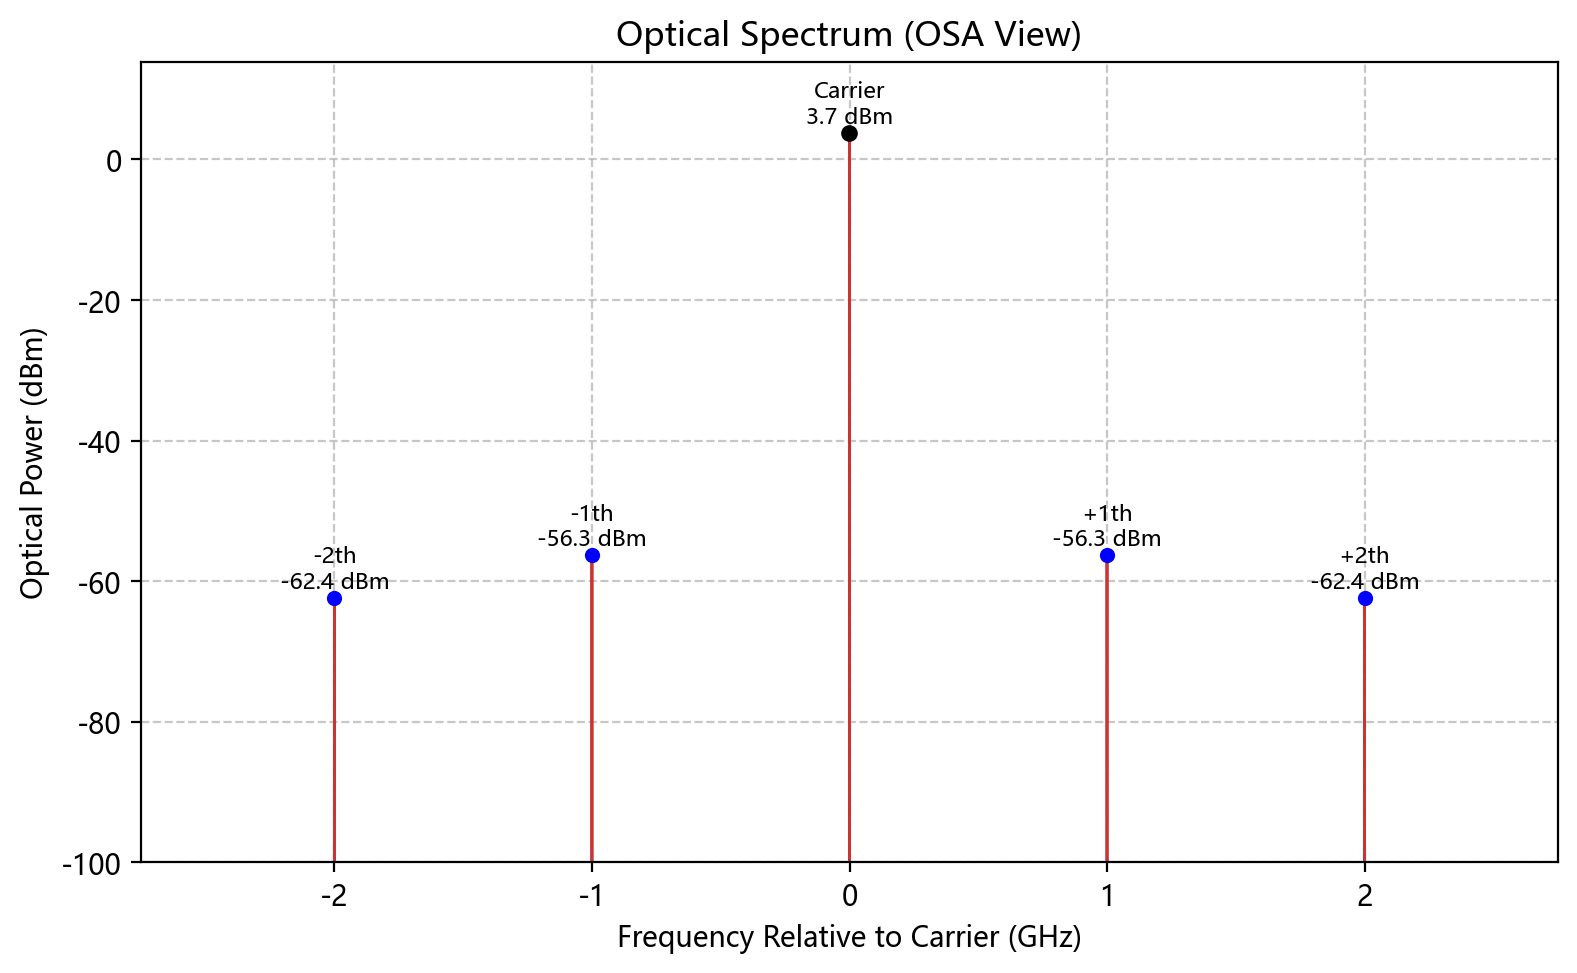

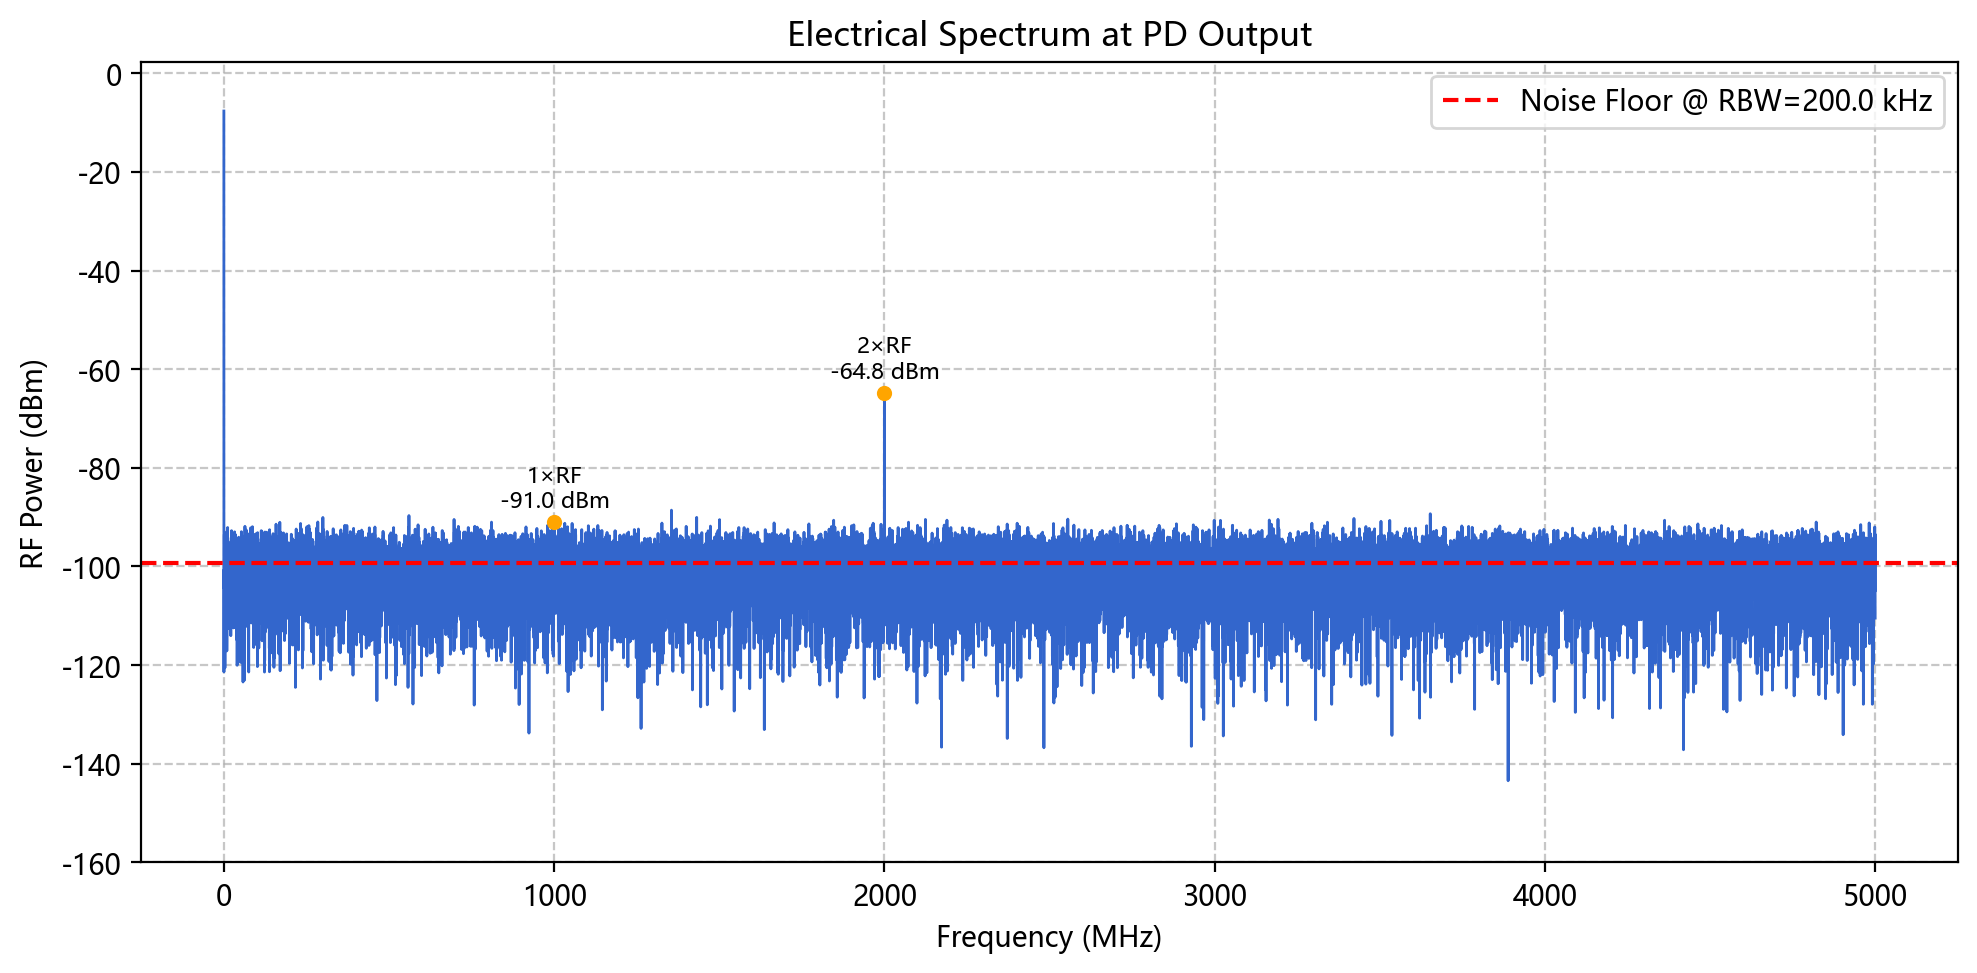

In [26]:
import matplotlib.pyplot as plt

from mzm.model import simulate_mzm, bias_to_theta_rad
from mzm.plot import plot_optical_spectrum_osa, plot_electrical_spectrum

%config InlineBackend.figure_format = 'retina'

# 设置中文字体与负号显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

model, meta = dc.load_model(MODEL_PATH)

# Choose a single target working point (deg)
target_deg = 0.0

# Initial bias: random by default.
# - Set init_seed to an integer for reproducible runs (e.g., 1).
# - Keep it as None to re-sample a different V_init each run.
init_seed = None
rng = np.random.default_rng(init_seed)
V_init = float(rng.uniform(0.0, float(meta['device_params'].Vpi_DC)))

theta_init_deg = float(np.rad2deg(bias_to_theta_rad(V_init, Vpi_DC=float(meta['device_params'].Vpi_DC))))

print('target_deg     :', target_deg)
print('init V (V)     :', V_init)
print('init theta (deg):', theta_init_deg)

# --- (A) Pre-control spectra at initial bias ---
print('\n[pre] spectra at V_init')
sim_pre = simulate_mzm(
    V_bias=V_init,
    Vpi_RF=float(meta['device_params'].Vpi_DC),
    Vpi_DC=float(meta['device_params'].Vpi_DC),
    ER_dB=float(meta['device_params'].ER_dB),
    IL_dB=float(meta['device_params'].IL_dB),
    Pin_dBm=float(meta['device_params'].Pin_dBm),
    Responsivity=float(meta['device_params'].Responsivity),
    R_load=float(meta['device_params'].R_load),
    # RF settings used only for spectrum illustration
    f_rf=1e9,
    V_rf_amp=0.2,
    Fs=100e9,
    T_total=5e-6,
 )
print('pre  P_pd_avg_dBm:', sim_pre.P_pd_avg_dBm)
plot_optical_spectrum_osa(sim_pre, f_rf_hz=1e9)
plot_electrical_spectrum(sim_pre, f_rf_hz=1e9)

# --- (B) Closed-loop rollout (dBm-only + history) ---
steps = 60
r = dc.rollout_dbm_hist(
    model=model,
    mu=meta['mu'],
    sigma=meta['sigma'],
    device_params=meta['device_params'],
    dither_params=meta['dither_params'],
    theta_target_deg=float(target_deg),
    V_init=V_init,
    steps=steps,
 )

V_final = float(r['V'][-1])
final_err = float(r['err_deg'][-1])
print('\n[rollout] final V:', V_final)
print('[rollout] final wrapped err (deg):', f"{final_err:+.2f}")

# Print per-iteration trace
print('\nPer-iteration trace:')
print(' iter |    V(V) |  theta(deg) |  err(deg) |   dV(V) |  p1(dBm) |  p2(dBm) | dp1(dB) | dp2(dB)')
for k in range(steps):
    print(
        f"{k+1:5d} |"
        f" {r['V'][k]:7.4f} |"
        f" {r['theta_deg'][k]:10.3f} |"
        f" {r['err_deg'][k]:8.3f} |"
        f" {r['dv'][k]:7.4f} |"
        f" {r['p1_dBm'][k]:8.2f} |"
        f" {r['p2_dBm'][k]:8.2f} |"
        f" {r['dp1_dBm'][k]:7.2f} |"
        f" {r['dp2_dBm'][k]:7.2f}"
    )

# Plot convergence curve
plt.figure(figsize=(8, 4))
plt.plot(r['err_deg'], label=f"target {target_deg:.0f}°")
plt.axhline(0.0, color='k', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Phase Error (deg, wrapped)')
plt.title('Closed-loop convergence (dBm-only + history)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- (C) Post-control spectra at final bias ---
print('\n[post] spectra at V_final')
sim_post = simulate_mzm(
    V_bias=V_final,
    Vpi_RF=float(meta['device_params'].Vpi_DC),
    Vpi_DC=float(meta['device_params'].Vpi_DC),
    ER_dB=float(meta['device_params'].ER_dB),
    IL_dB=float(meta['device_params'].IL_dB),
    Pin_dBm=float(meta['device_params'].Pin_dBm),
    Responsivity=float(meta['device_params'].Responsivity),
    R_load=float(meta['device_params'].R_load),
    f_rf=1e9,
    V_rf_amp=0.2,
    Fs=100e9,
    T_total=5e-6,
 )
print('post P_pd_avg_dBm:', sim_post.P_pd_avg_dBm)
plot_optical_spectrum_osa(sim_post, f_rf_hz=1e9)
plot_electrical_spectrum(sim_post, f_rf_hz=1e9)